In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

데이터 분석 결과로 두 가지 중요한 패턴을 발견했습니다:

- <b>biscuit thickness</b>가 60을 초과할 경우 모든 제품이 실패합니다.  
- <b>cast pressure</b>가 149 이하일 경우에도 모든 제품이 실패합니다.

In [ ]:
def create_features(X):
    X['is_biscuit_thick'] = (X['biscuit_thickness'] > 60).astype(int)
    X['is_cast_pressure_low'] = (X['cast_pressure'] < 149).astype(int)

    return X

In [ ]:
# 데이터를 불러오기
data = pd.read_csv('dataset.csv', encoding='cp949', index_col=0)
data.tail()

,line,name,mold_name,time,date,count,working,emergency_stop,molten_temp,facility_operation_cycleTime,...,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,registration_time,passorfail,tryshot_signal,mold_code,heating_furnace
92010,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:51:29,71,가동,ON,731.0,122,...,1449.0,279.0,726.0,30.0,0,2019-03-31 23:51:29,0.0,NaN,8917,A
92011,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:53:28,72,가동,ON,731.0,120,...,1449.0,279.0,732.0,30.0,0,2019-03-31 23:53:28,0.0,NaN,8917,A
92012,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:55:44,73,가동,ON,732.0,122,...,1449.0,272.0,731.0,30.0,0,2019-03-31 23:55:44,0.0,NaN,8917,A
92013,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:57:46,74,가동,ON,732.0,133,...,1449.0,288.0,723.0,30.0,0,2019-03-31 23:57:46,0.0,NaN,8917,A
92014,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:59:48,75,가동,ON,732.0,122,...,1449.0,289.0,705.0,30.0,0,2019-03-31 23:59:48,0.0,NaN,8917,A


In [ ]:
data_copy = data.copy()
# object 타입이 아닌 데이터를 가지기
use_col = data_copy.dtypes[data.dtypes !='object'].index
data_copy = data_copy[use_col]
data_copy

,count,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,molten_volume,cast_pressure,biscuit_thickness,upper_mold_temp1,...,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,mold_code
0,258,731.0,119,120,110.0,112.0,75.0,331.0,35.0,198.0,...,1449.0,234.0,316.0,1449.0,550.0,700.0,34.0,23,0.0,8722
1,243,720.0,98,125,109.0,109.0,NaN,309.0,48.0,250.0,...,NaN,208.0,163.0,NaN,481.0,0.0,30.0,25,0.0,8412
2,244,721.0,98,122,109.0,109.0,NaN,309.0,48.0,250.0,...,NaN,208.0,163.0,NaN,481.0,0.0,30.0,25,0.0,8412
3,245,721.0,100,125,112.0,109.0,NaN,308.0,49.0,268.0,...,NaN,211.0,179.0,NaN,483.0,0.0,30.0,25,0.0,8412
4,246,721.0,99,123,109.0,110.0,NaN,309.0,49.0,276.0,...,NaN,216.0,187.0,NaN,486.0,0.0,30.0,25,0.0,8412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92010,71,731.0,122,122,100.0,101.0,NaN,331.0,49.0,83.0,...,1449.0,231.0,201.0,1449.0,279.0,726.0,30.0,0,0.0,8917
92011,72,731.0,120,121,100.0,101.0,NaN,331.0,54.0,83.0,...,1449.0,232.0,201.0,1449.0,279.0,732.0,30.0,0,0.0,8917
92012,73,732.0,122,135,100.0,101.0,NaN,331.0,52.0,79.0,...,1449.0,225.0,195.0,1449.0,272.0,731.0,30.0,0,0.0,8917
92013,74,732.0,133,122,100.0,101.0,NaN,331.0,53.0,82.0,...,1449.0,227.0,199.0,1449.0,288.0,723.0,30.0,0,0.0,8917


In [ ]:
data_copy.columns

Index(['count', 'molten_temp', 'facility_operation_cycleTime',
       'production_cycletime', 'low_section_speed', 'high_section_speed',
       'molten_volume', 'cast_pressure', 'biscuit_thickness',
       'upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3',
       'lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3',
       'sleeve_temperature', 'physical_strength', 'Coolant_temperature',
       'EMS_operation_time', 'passorfail', 'mold_code'],
      dtype='object')

In [ ]:
data_copy.shape

(92015, 21)

In [ ]:
# null인 행들 보기
data_copy.isnull().sum()

,0
count,0
molten_temp,2261
facility_operation_cycleTime,0
production_cycletime,0
low_section_speed,1
high_section_speed,1
molten_volume,45130
cast_pressure,1
biscuit_thickness,1
upper_mold_temp1,1


In [ ]:
# # null 값이 많아서 molten_volume 열을 drop하기
# data_copy.drop('molten_volume', axis=1, inplace=True)

# # null인 값들을 평균으로 대체하기
# columns_to_fill = ['molten_temp', 'upper_mold_temp3', 'lower_mold_temp3']
# data_copy[columns_to_fill] = data_copy[columns_to_fill].fillna(data_copy[columns_to_fill].mean())

# # 모든 값이 null인 행을 drop하기
# data_copy.dropna(axis=0, inplace=True)

# data_copy.reset_index(drop=True, inplace=True)
# data_copy

In [ ]:
# null 값이 많아서 molten_volume 열을 drop하기
# data_copy.drop('molten_volume', axis=1, inplace=True)

# null인 값들을 평균으로 대체하기
columns_to_fill = ['molten_volume', 'molten_temp', 'upper_mold_temp3', 'lower_mold_temp3']
# data_copy[columns_to_fill] = data_copy[columns_to_fill].fillna(data_copy[columns_to_fill].mean())

data_copy.drop(columns_to_fill, axis=1, inplace=True)

# 모든 값이 null인 행을 drop하기
data_copy.dropna(axis=0, inplace=True)

data_copy.reset_index(drop=True, inplace=True)
data_copy

,count,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,lower_mold_temp1,lower_mold_temp2,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,mold_code
0,258,119,120,110.0,112.0,331.0,35.0,198.0,116.0,234.0,316.0,550.0,700.0,34.0,23,0.0,8722
1,243,98,125,109.0,109.0,309.0,48.0,250.0,113.0,208.0,163.0,481.0,0.0,30.0,25,0.0,8412
2,244,98,122,109.0,109.0,309.0,48.0,250.0,113.0,208.0,163.0,481.0,0.0,30.0,25,0.0,8412
3,245,100,125,112.0,109.0,308.0,49.0,268.0,122.0,211.0,179.0,483.0,0.0,30.0,25,0.0,8412
4,246,99,123,109.0,110.0,309.0,49.0,276.0,128.0,216.0,187.0,486.0,0.0,30.0,25,0.0,8412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92009,71,122,122,100.0,101.0,331.0,49.0,83.0,183.0,231.0,201.0,279.0,726.0,30.0,0,0.0,8917
92010,72,120,121,100.0,101.0,331.0,54.0,83.0,184.0,232.0,201.0,279.0,732.0,30.0,0,0.0,8917
92011,73,122,135,100.0,101.0,331.0,52.0,79.0,184.0,225.0,195.0,272.0,731.0,30.0,0,0.0,8917
92012,74,133,122,100.0,101.0,331.0,53.0,82.0,185.0,227.0,199.0,288.0,723.0,30.0,0,0.0,8917


In [ ]:
# 필요 없는 열을 drop하기
data_copy.drop(['count', 'EMS_operation_time', 'mold_code'], axis=1, inplace=True)
data_copy

,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,lower_mold_temp1,lower_mold_temp2,sleeve_temperature,physical_strength,Coolant_temperature,passorfail
0,119,120,110.0,112.0,331.0,35.0,198.0,116.0,234.0,316.0,550.0,700.0,34.0,0.0
1,98,125,109.0,109.0,309.0,48.0,250.0,113.0,208.0,163.0,481.0,0.0,30.0,0.0
2,98,122,109.0,109.0,309.0,48.0,250.0,113.0,208.0,163.0,481.0,0.0,30.0,0.0
3,100,125,112.0,109.0,308.0,49.0,268.0,122.0,211.0,179.0,483.0,0.0,30.0,0.0
4,99,123,109.0,110.0,309.0,49.0,276.0,128.0,216.0,187.0,486.0,0.0,30.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92009,122,122,100.0,101.0,331.0,49.0,83.0,183.0,231.0,201.0,279.0,726.0,30.0,0.0
92010,120,121,100.0,101.0,331.0,54.0,83.0,184.0,232.0,201.0,279.0,732.0,30.0,0.0
92011,122,135,100.0,101.0,331.0,52.0,79.0,184.0,225.0,195.0,272.0,731.0,30.0,0.0
92012,133,122,100.0,101.0,331.0,53.0,82.0,185.0,227.0,199.0,288.0,723.0,30.0,0.0


In [ ]:
# 새로운 feature 생성하기
# data_copy = create_features(data_copy)

In [ ]:
# input and target variables
X = data_copy.drop('passorfail', axis=1).values
y = data_copy['passorfail'].values

In [ ]:
X

array([[119., 120., 110., ..., 550., 700.,  34.],
       [ 98., 125., 109., ..., 481.,   0.,  30.],
       [ 98., 122., 109., ..., 481.,   0.,  30.],
       ...,
       [122., 135., 100., ..., 272., 731.,  30.],
       [133., 122., 100., ..., 288., 723.,  30.],
       [122., 123., 100., ..., 289., 705.,  30.]])

In [ ]:
# data splitting
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # %80 학습
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # %10 검증, %10 테스트

# 클래스 가중치 결정하기 (불균형 데이터 구조)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# neural network 구조 만들기
model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu',kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

# 모델 compile하기
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습하기
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    class_weight=class_weights,
                    validation_data=(X_valid,y_valid), callbacks=[early_stopping])

Epoch 1/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.4932 - loss: 1.4006 - val_accuracy: 0.8883 - val_loss: 0.9220
Epoch 2/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6122 - loss: 1.0012 - val_accuracy: 0.9286 - val_loss: 0.8853
Epoch 3/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7022 - loss: 0.8446 - val_accuracy: 0.9620 - val_loss: 0.8131
Epoch 4/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7757 - loss: 0.7709 - val_accuracy: 0.9770 - val_loss: 0.7926
Epoch 5/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8245 - loss: 0.7176 - val_accuracy: 0.9771 - val_loss: 0.6800
Epoch 6/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8614 - loss: 0.6597 - val_accuracy: 0.9746 - val_loss: 0.6538
Epoch 7/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8882 - loss: 0.6233 - val_accuracy: 0.9797 - val_loss: 0.6373
Epoch 8/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9068 - loss: 0.5960 - val_accuracy: 0

<h3> 모델 성능 평가하기 </h3>

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Model Loss: {loss:.4f}")
print(f"Model Accuracy: {accuracy:.4f}")

576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9783 - loss: 0.2367
Model Loss: 0.2366
Model Accuracy: 0.9792


In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
report = classification_report(y_test, y_pred, target_names=['Pass', 'Fail'])
print(report)

576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

        Pass       0.99      0.99      0.99     17596
        Fail       0.74      0.80      0.77       807

    accuracy                           0.98     18403
   macro avg       0.87      0.89      0.88     18403
weighted avg       0.98      0.98      0.98     18403



In [ ]:
test_report = classification_report(y_test, y_pred, target_names=['Pass', 'Fail'], output_dict = True)
test_macro_accuracy = (test_report['Pass']['precision'] + test_report['Fail']['precision']) / 2
print(f"Test Macro Accuracy: {test_macro_accuracy:.4f}")

Test Macro Accuracy: 0.8678


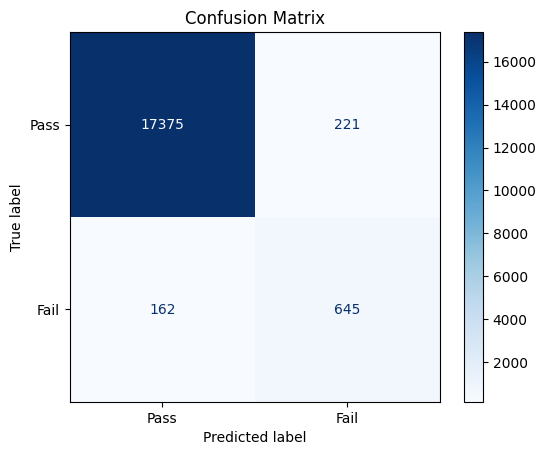

In [ ]:
# confusion matrix 시각화하기
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pass', 'Fail'])
disp.plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

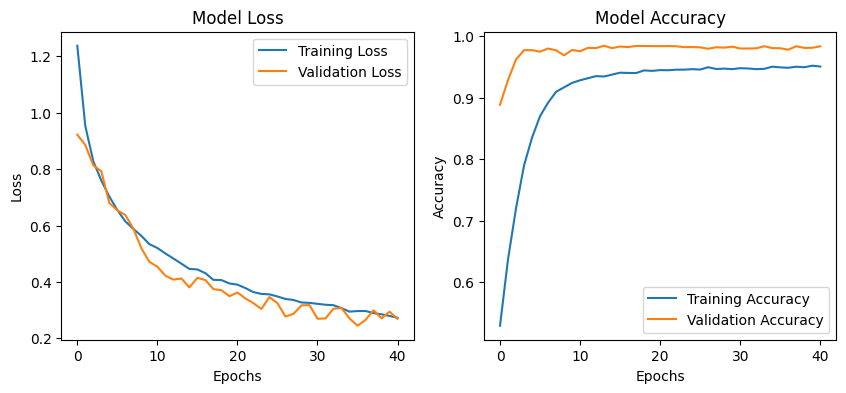

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()